# Introduction

This notebook visualizes the distribution of grid angels for selected Danish towns and cities.

This notebook is a slightly modified version of [this notebook](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/17-street-network-orientations.ipynb) made by [Geoff Boing](https://geoffboeing.com/). 




Instead of downloading a polygon I draw a circle around the center of towns and cities. This is done because polygons for towns rather than municipalities are not present for most Danish towns in OpenStreetMaps. Including the full municipalities completely disguises any patterns in the street network. It requires however a bit of hand-holding to define the relevant radius.



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import seaborn as sns
sns.set_style("white")
%matplotlib inline
from zipfile import ZipFile


ox.config(log_console=True, use_cache=True)
weight_by_length = False

# Get Polygons

In [14]:
# define the study sites as label : query
places = {'Copenhagen'       : 'Copenhagen',
          'Aarhus'        : 'Aarhus',
          'Odense': 'Odense',
          'Aalborg': 'Aalborg',
          'Esbjerg': 'Esbjerg',
          'Randers': 'Randers rådhus',
          'Kolding':'Kolding',
          'Roskilde': 'Roskilde',
          'Vejle':'Vejle'}

Get datapoints for center of city and construct a 5k radius polygon.
The big cities get a slightly larger radius, which I adjusts manually.

"Randers" points to Randers South West. I therefore take the old city hall as the center. 

In [5]:
gdf = ox.gdf_from_places(places.values())
gdf['place_name_osm'] = gdf['place_name']
gdf['place_name'] = gdf['place_name'].apply(lambda s: s.split(' ')[0].split(',')[0])

crs_orig = gdf.crs
gdf = gdf.to_crs({'init': 'epsg:25832'})
gdf['geometry_old'] = gdf['geometry']
gdf.geometry = gdf.geometry.buffer(1200)
gdf.loc[gdf['place_name']=='Copenhagen','geometry'] =gdf.loc[gdf['place_name']=='Copenhagen','geometry_old'].values[0].buffer(3000) 
gdf.loc[gdf['place_name']=='Aarhus','geometry'] =gdf.loc[gdf['place_name']=='Aarhus','geometry_old'].values[0].buffer(2000) 
gdf.loc[gdf['place_name']=='Aalborg','geometry'] =gdf.loc[gdf['place_name']=='Aalborg','geometry_old'].values[0].buffer(2000) 
gdf.loc[gdf['place_name_osm'].apply(lambda s: 'Randers' in s),'place_name'] = 'Randers'
gdf = gdf.to_crs(crs_orig)



In [6]:
gdf

,bbox_east,bbox_north,bbox_south,bbox_west,geometry,place_name,place_name_osm,geometry_old
0,12.730072,55.846724,55.526724,12.410072,"POLYGON ((12.61769412278203 55.68532865312937,...",Copenhagen,"Copenhagen, Copenhagen Municipality, Capital R...",POINT (724402.4285127167 6176991.317334414)
1,10.373405,56.309628,55.989628,10.053405,"POLYGON ((10.24558936028881 56.14930758428454,...",Aarhus,"Aarhus, Aarhus Municipality, Central Denmark R...",POINT (575382.612873102 6223395.919756773)
2,10.545210,55.559722,55.239722,10.225210,"POLYGON ((10.40415278985638 55.39950646764044,...",Odense,"Odense, Odense Kommune, Region of Southern Den...",POINT (587723.766491371 6140146.551961462)
3,10.079394,57.208221,56.888221,9.759394,"POLYGON ((9.952355001336324 57.04797435053845,...",Aalborg,"Aalborg, Aalborg Municipality, North Denmark R...",POINT (555777.9942945659 6323129.172676276)
4,8.612075,55.626489,55.306489,8.292075,"POLYGON ((8.471054344357041 55.46657267537125,...",Esbjerg,"Esbjerg, Esbjerg Municipality, Region of South...",POINT (465358.0544884846 6146840.328822754)
5,10.037133,56.460948,56.460749,10.036901,"POLYGON ((10.01781820067521 56.46291274504842,...",Randers,"Det gamle Rådhus, Rosengade, Vorup, Randers, R...","POLYGON ((563896.3985465674 6257845.600918867,..."
6,9.639050,55.649500,55.329500,9.319050,"POLYGON ((9.498040415064477 55.48942413848378,...",Kolding,"Kolding, Kolding Municipality, Region of South...",POINT (530269.8041171364 6149368.956792926)
7,12.241925,55.803348,55.483348,11.921925,"POLYGON ((12.10096231027899 55.64286774871677,...",Roskilde,"Roskilde, Roskilde Municipality, Region Zealan...",POINT (693945.3155016822 6170694.156159081)
8,9.693324,55.860006,55.540006,9.373324,"POLYGON ((9.552415982161824 55.69992130511118,...",Vejle,"Vejle, Vejle Municipality, Region of Southern ...",POINT (533519.256950374 6172820.727981888)


# Constructing histograms

In [7]:
def reverse_bearing(x):
    return x + 180 if x < 180 else x - 180

In [8]:
bearings = {}
graphs = {}
for idx,row in tqdm(gdf.iterrows()):
    #print(row)
    place = row['place_name']
    #place_name = place.split(',')[0]
    # get the graph
    query = row['geometry']
    
    G = ox.graph_from_polygon(query, network_type='drive')
    
    # calculate edge bearings
    Gu = ox.add_edge_bearings(ox.get_undirected(G))
    
    if weight_by_length:
        # weight bearings by length (meters)
        city_bearings = []
        for u, v, k, d in Gu.edges(keys=True, data=True):
            city_bearings.extend([d['bearing']] * int(d['length']))
        b = pd.Series(city_bearings)
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    else:
        # don't weight bearings, just take one value per street segment
        b = pd.Series([d['bearing'] for u, v, k, d in Gu.edges(keys=True, data=True)])
        bearings[place] = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop='True')
    graphs[place] = G

9it [01:10,  7.85s/it]


# Plotting functions

In [9]:

def count_and_merge(n, bearings):
    # make twice as many bins as desired, then merge them in pairs
    # prevents bin-edge effects around common values like 0° and 90°
    n = n * 2
    bins = np.arange(n + 1) * 360 / n
    count, _ = np.histogram(bearings, bins=bins)
    
    # move the last bin to the front, so eg 0.01° and 359.99° will be binned together
    count = np.roll(count, 1)
    return count[::2] + count[1::2]

In [10]:
# function to draw a polar histogram for a set of edge bearings
def polar_plot(ax, bearings, n=36, title=''):

    bins = np.arange(n + 1) * 360 / n
    count = count_and_merge(n, bearings)
    _, division = np.histogram(bearings, bins=bins)
    frequency = count / count.sum()
    division = division[0:-1]
    width =  2 * np.pi / n

    ax.set_theta_zero_location('N')
    ax.set_theta_direction('clockwise')

    x = division * np.pi / 180
    bars = ax.bar(x, height=frequency, width=width, align='center', bottom=0, zorder=2,
                  color=sns.xkcd_rgb['bordeaux'], edgecolor='k', linewidth=0.5, alpha=0.8)
    
    ax.set_ylim(top=frequency.max())
    
    title_font = {'family':'Century Gothic', 'size':24, 'weight':'bold'}
    xtick_font = {'family':'Century Gothic', 'size':10, 'weight':'bold', 'alpha':1.0, 'zorder':3}
    ytick_font = {'family':'Century Gothic', 'size': 9, 'weight':'bold', 'alpha':0.2, 'zorder':3}
    
    ax.set_title(title.upper(), y=1.05, fontdict=title_font)
    
    ax.set_yticks(np.linspace(0, max(ax.get_ylim()), 5))
    yticklabels = ['{:.2f}'.format(y) for y in ax.get_yticks()]
    yticklabels[0] = ''
    ax.set_yticklabels(labels=yticklabels, fontdict=ytick_font)
    
    xticklabels = ['N', '', 'E', '', 'S', '', 'W', '']
    ax.set_xticklabels(labels=xticklabels, fontdict=xtick_font)
    ax.tick_params(axis='x', which='major', pad=-2)

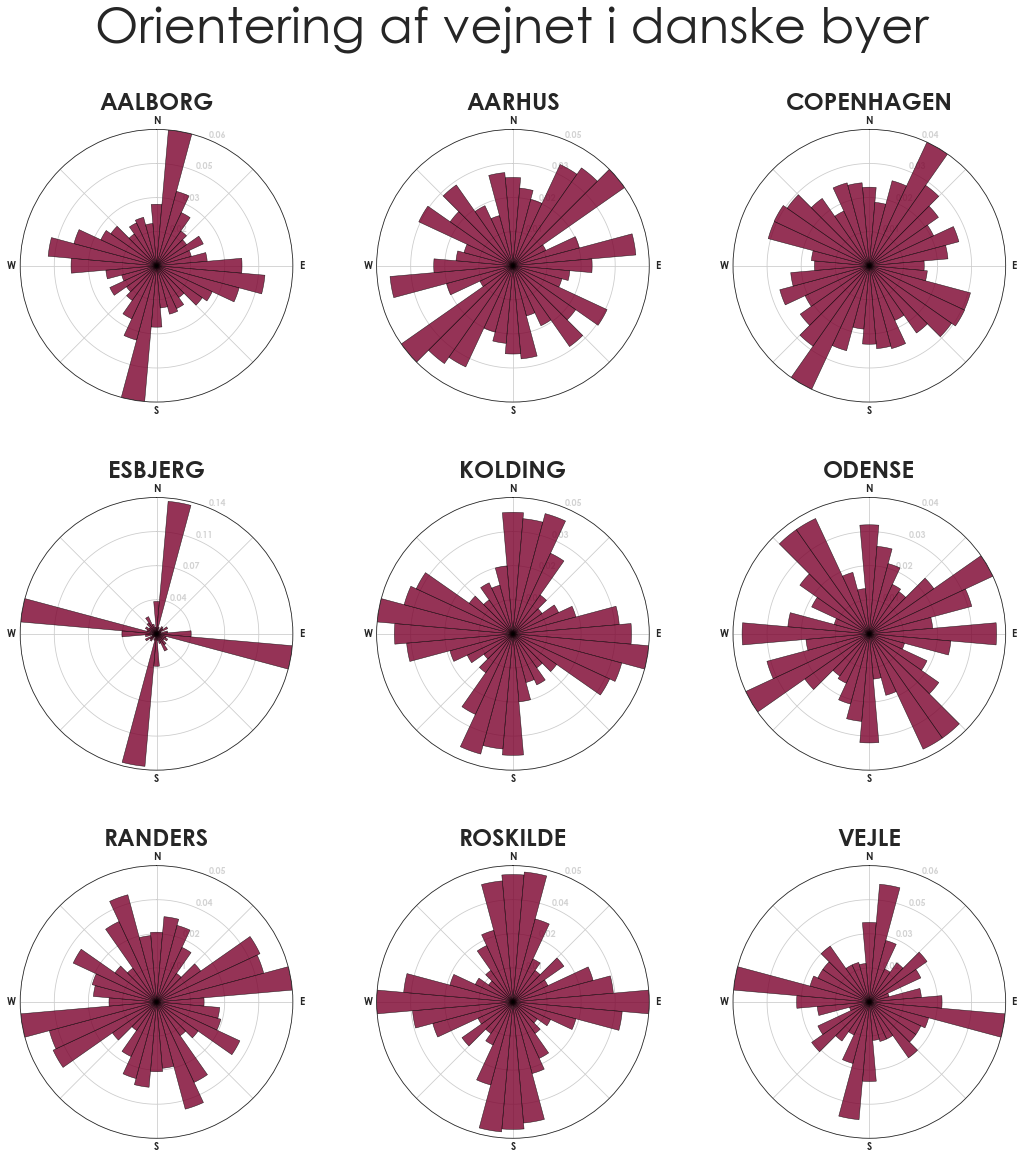

In [15]:
# create figure and axes
n = len(places)
ncols = int(np.ceil(np.sqrt(n)))
nrows = int(np.ceil(n / ncols))
figsize = (ncols * 5, nrows * 5)
fig, axes = plt.subplots(nrows, ncols, figsize=figsize, subplot_kw={'projection':'polar'})

# plot each city's polar histogram
for ax, place in zip(axes.flat, sorted(places.keys())):
    polar_plot(ax, bearings[place].dropna(), title=place)

# add super title and save full image
suptitle_font = {'family':'Century Gothic', 'fontsize':50, 'fontweight':'normal', 'y':1.07}
fig.suptitle('Orientering af vejnet i danske byer', **suptitle_font)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35)
fig.savefig('images/street-orientations.png', dpi=120, bbox_inches='tight',transparent=False)
plt.show()
plt.close()

# Include map

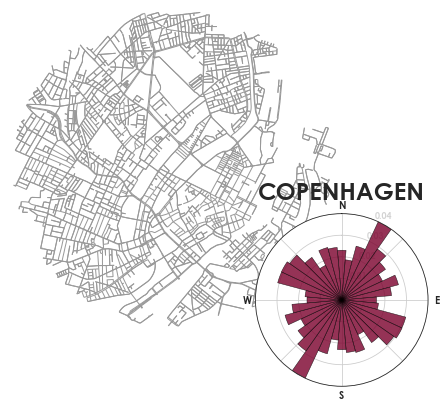

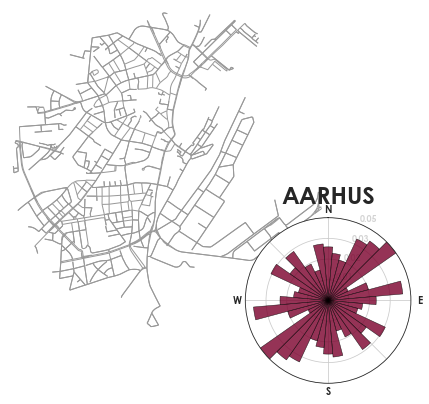

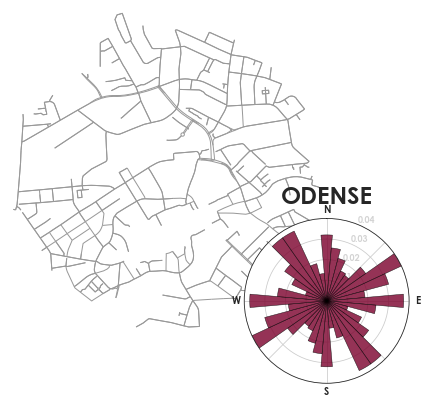

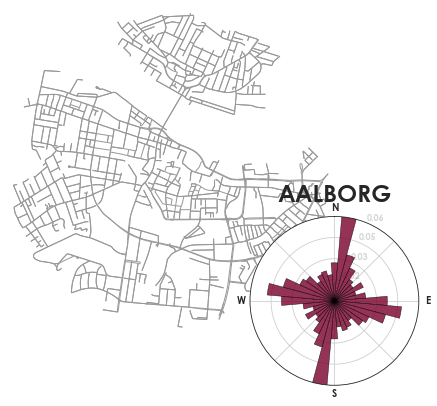

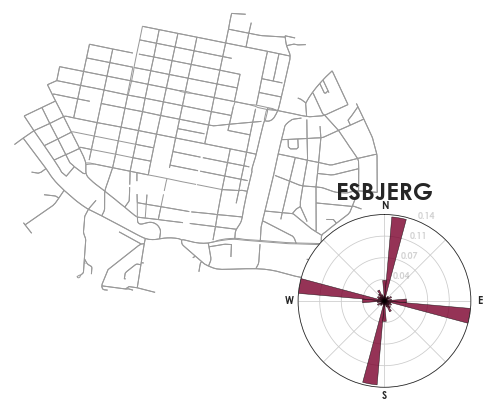

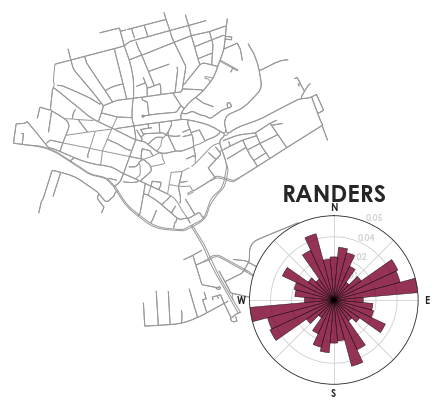

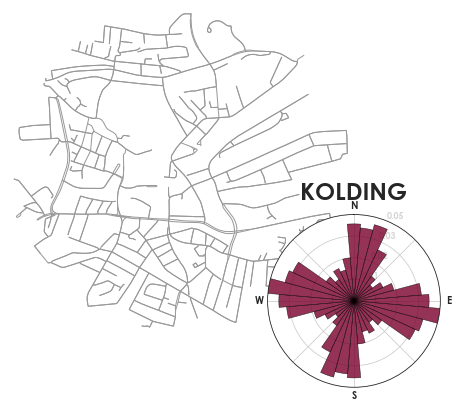

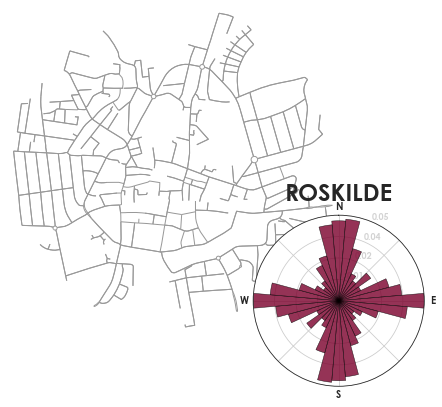

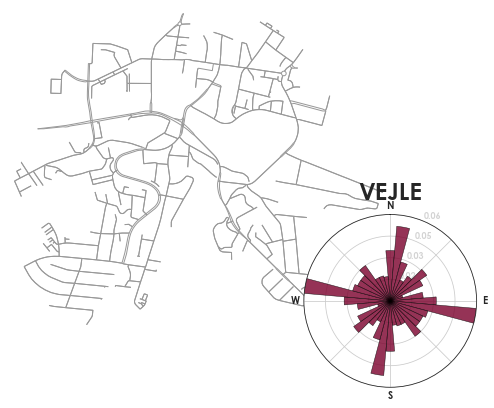

In [16]:
for place in places:
    fig, ax = ox.plot_graph(ox.project_graph(graphs[place]), node_size=0,close=False,show=False)
    ax2 =fig.add_axes([.7,0,.4,.4], projection='polar')
    polar_plot(ax2, bearings[place].dropna(), title=place)
    fig.savefig('images/orientation_'+place+'.png', dpi=120, bbox_inches='tight')
    plt.show()
    